# Trabalho Final - Análise de Dados com Python

Integrantes:

    1) Lais Alvarenga (352468)
    2) Bruno Igor (352119)
    3) Gabriel ()
    4) Jaqueline ()

### Enunciado
O departamento de crédito da QuantumFinance solicitou a criação de um algoritmo para predizer o valor dos imóveis em determinada região a fim de mensurarem a provisão de crédito para o próximo ano. Assim, baseado no dataset disponível, use Regressão Linear Multivariada para predizer o valor dos imóveis com um RMSE abaixo de 69000. [dataset](https://github.com/ageron/handson-ml2/tree/master/datasets/housing)

Links úteis:

[Linear Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

[RMSE](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html#sklearn.metrics.mean_squared_error)

[Train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

Roteiro de atividade:

> Definição do problema

> Aquisição de dados de treinamento e teste

> Manipulação, preparo e limpeza dos dados

> Análise, identificação de padrão e exploração dos dados

> Modelagem, predição e resolução do problema

> Visualização e apresentação da solução final

## Definição do problema

A partir de um conjunto de treino que lista caracteristicas de um imovel em determinada região, é possivel criar um modelo que determine o valor dos imoveis?

## Aquisição de dados

In [1]:
# leitura dos dados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import radians, cos, sin, asin, sqrt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

housing = pd.read_csv('housing.csv')

In [2]:
housing.info()
print()
print('-'*40)
print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB

----------------------------------------



In [3]:
#somente total_bedrooms possui nulo (nulo nesse caso = 0?):
#parece melhor substituir pela mediana dado que nao está claro pelo dataset e contexto se nulo em total bedrooms seria equivalente a zero
#como sao poucos dados nulos, apenas 207 registros (1%), qualquer substituicao nao deve interferir nos resultados do modelo

housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


## Exploratória de dados:
1. Latitude e longitude so fazem sentido se forem usadas como pares ordenados
2. Total rooms, total bedrooms, population e households possuem outliers, tanto para mais quanto para menos (vide boxplot)
3. Total bedrooms tem que ser preenchido com a mediana
4. Ajuste de outlier e criaação de variaveis dummy 
5. Descarte das variaveis que não serão utilizadas

#### 1. Ajustando lat e long para que as coordenadas nos digam a distancia com relacao ao ponto zero

In [4]:
def single_pt_haversine(lat, lng, degrees=True):
    """
    'Single-point' Haversine: calcula distancia entre lat-long e o ponto (0,0)
    """
    r = 6371 # Raio da terra em km.

    # Converte graus decimais em radianos
    if degrees:
        lat, lng = map(radians, [lat, lng])

    # Formula 'Single-point' Haversine 
    a = sin(lat/2)**2 + cos(lat) * sin(lng/2)**2
    d = 2 * r * asin(sqrt(a)) 

    return d

housing['harvesine_distance'] = [single_pt_haversine(latitude, longitude) for latitude, longitude in zip(housing.latitude, housing.longitude)]

#### 2. Analisando o boxplot/histograma das variaveis

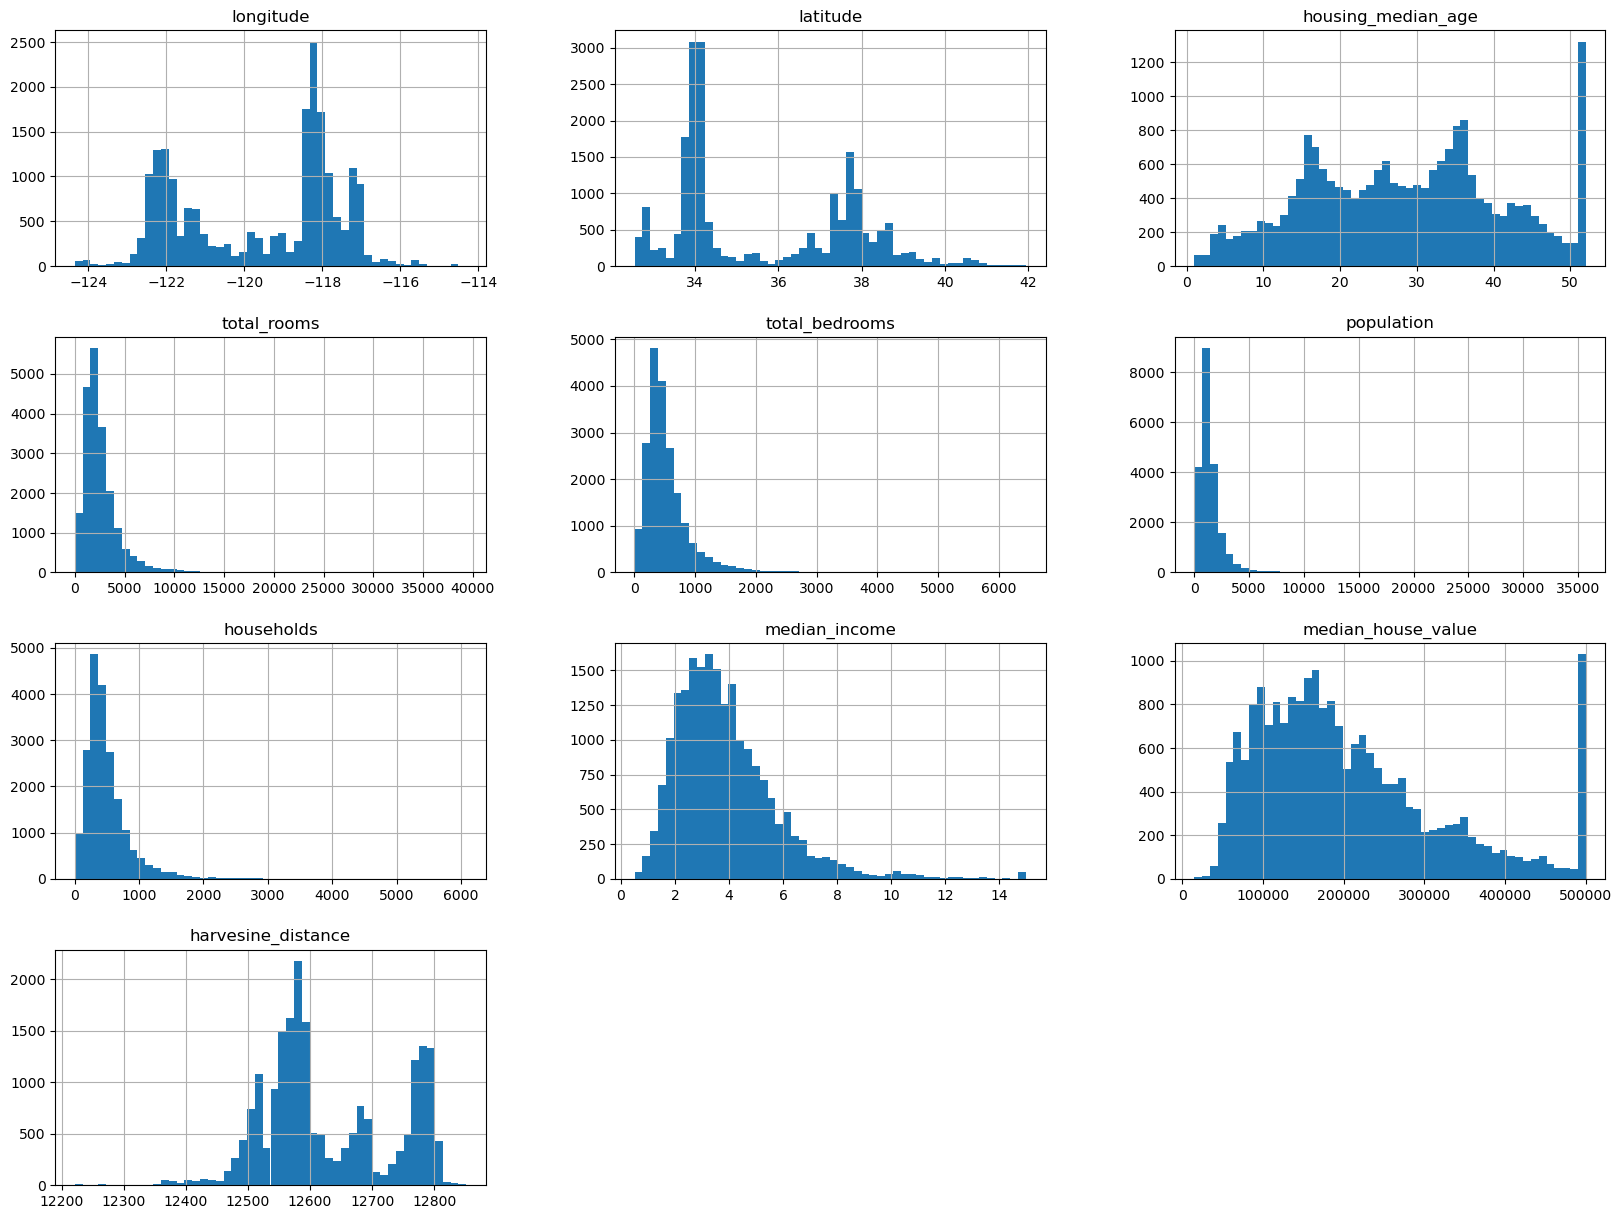

In [5]:
#histograma das variaveis numéricas
housing.hist(bins=50, figsize=(20,15))
plt.show()

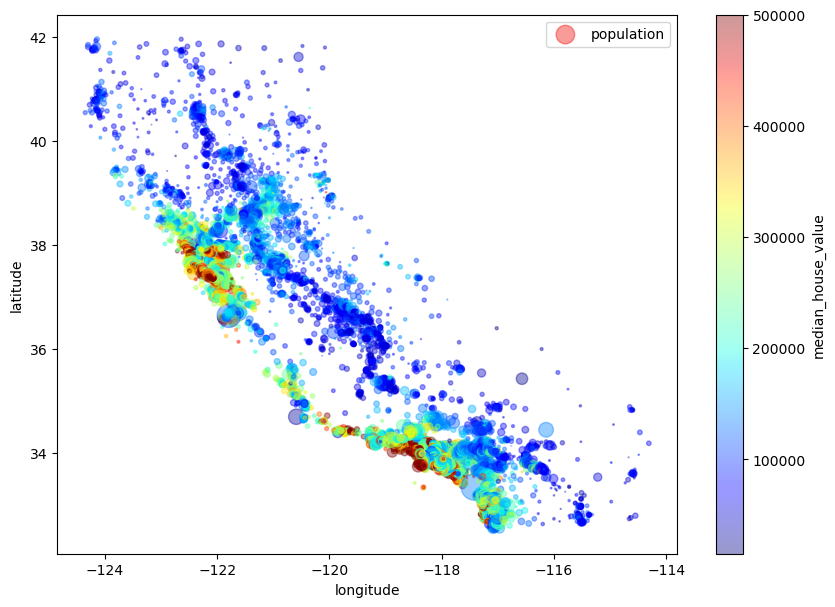

In [6]:
#distribuicao de densidade populacional por localidade 
#mapa de calor do valor medio da casa
#pontos com alta concentracao populacional com todo tipo de valor de casa
#localidades com menos densidade populacional tem valores medios de casa mais baratos

housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=housing["population"]/100, label="population", figsize=(10,7),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)
plt.legend()
plt.show()

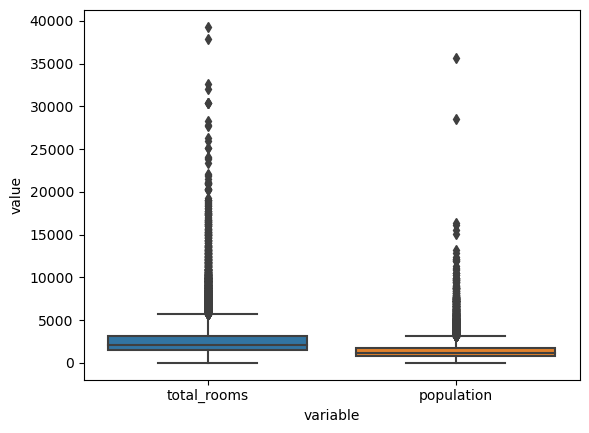

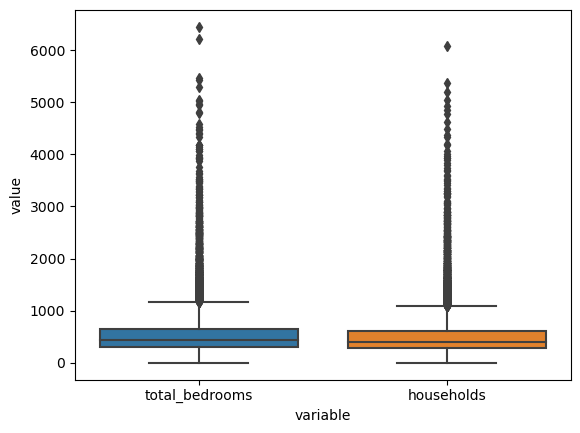

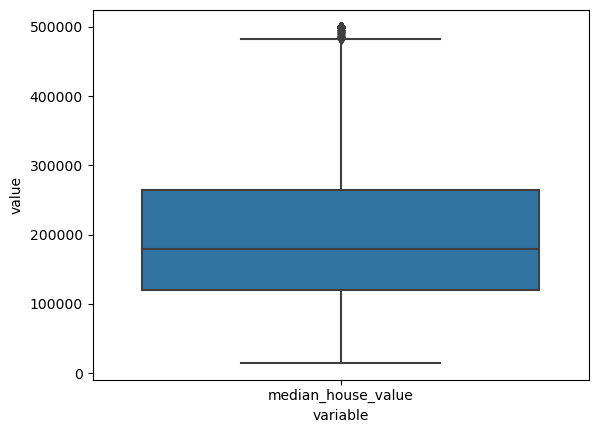

In [7]:
#separando a figura do boxplot em duas para que as variaveis com escalas parecidas fiquem 
#em uma unica figura
df = pd.DataFrame(housing, columns = ['total_rooms','population'])
sns.boxplot(x="variable", y="value", data=pd.melt(df))
plt.show()

df = pd.DataFrame(housing, columns = ['total_bedrooms','households'])
sns.boxplot(x="variable", y="value", data=pd.melt(df))
plt.show()

df = pd.DataFrame(housing, columns = ['median_house_value'])
sns.boxplot(x="variable", y="value", data=pd.melt(df))
plt.show()

In [8]:
#analisando os percentis para pegar os valores exatos dos percentis 1 e 99 para substituir:
#obs: o restante das outras variaveis nao tem um dp tao alto, por isso, nao serão substituidas
def percentil(df, coluna):
    return df[coluna].describe(percentiles=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

def decil(df, coluna):
    return df[coluna].describe(percentiles=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

lista_vars = ['total_rooms','population','total_bedrooms','households', 'median_income'] 
for i in lista_vars:
    print(percentil(housing,i))
    print("\n")
    
decil(housing, 'population')

count    20640.000000
mean      2635.763081
std       2181.615252
min          2.000000
1%         164.000000
5%         620.950000
10%        941.000000
25%       1447.750000
50%       2127.000000
75%       3148.000000
90%       4651.500000
95%       6213.200000
99%      11212.110000
max      39320.000000
Name: total_rooms, dtype: float64


count    20640.000000
mean      1425.476744
std       1132.462122
min          3.000000
1%          88.000000
5%         348.000000
10%        510.000000
25%        787.000000
50%       1166.000000
75%       1725.000000
90%       2566.000000
95%       3288.000000
99%       5805.830000
max      35682.000000
Name: population, dtype: float64


count    20433.000000
mean       537.870553
std        421.385070
min          1.000000
1%          36.000000
5%         137.000000
10%        198.000000
25%        296.000000
50%        435.000000
75%        647.000000
90%        965.000000
95%       1275.400000
99%       2221.360000
max       6445.000000
Name:

count    20640.000000
mean      1425.476744
std       1132.462122
min          3.000000
10%        510.000000
20%        710.000000
30%        859.000000
40%       1007.000000
50%       1166.000000
60%       1348.400000
70%       1580.000000
80%       1908.000000
90%       2566.000000
max      35682.000000
Name: population, dtype: float64

#### 3. Substituindo nulos pela mediana em 'total_bedrooms'

In [9]:
# substituindo nulo pela mediana de acordo com quem está na mesma distancia ao ponto zero
housing['total_bedrooms'] = housing['total_bedrooms'].fillna(housing.groupby('harvesine_distance')['total_bedrooms'].transform('median'))
#83 registros continuam com nulo pois nao foi encontrado outros registros na base com o mesmo valor em harvesine distance, sendo assim, substituirei pela mediana da base toda
housing['total_bedrooms'].fillna(housing['total_bedrooms'].median(), inplace=True)

In [10]:
housing.info()
print()
print('-'*40)
print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20640 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
 10  harvesine_distance  20640 non-null  float64
dtypes: float64(10), object(1)
memory usage: 1.7+ MB

----------------------------------------



#### 4. Substituindo/transformando variaveis

In [11]:
#Ajuste de outliers
housing['total_rooms'] = np.where(housing['total_rooms'] <= 164, 164,
                                  np.where(housing['total_rooms'] >= 11212.11, 11212.11,
                                           housing['total_rooms']))

housing['total_bedrooms'] = np.where(housing['total_bedrooms'] <= 36, 36,
                                     np.where(housing['total_bedrooms'] >= 2221.36, 2221.36,
                                              housing['total_bedrooms']))

housing['population'] = np.where(housing['population'] <= 88, 88,
                                     np.where(housing['population'] >= 5805.83, 5805.83,
                                              housing['population']))

housing['households'] = np.where(housing['households'] <= 31, 31,
                                     np.where(housing['households'] >= 1982.66, 1982.66, 
                                              housing['households']))

housing['harvesine_distance'] = np.where(housing['harvesine_distance'] <= 12556.40, 1,
                                     np.where(housing['harvesine_distance'] <= 12590.80, 2,
                                              np.where(housing['harvesine_distance'] <= 12739.77, 3, 4)))

In [12]:
#Analise para criação da variável dummy:
housing.groupby('ocean_proximity')['median_house_value'].describe()

,count,mean,std,min,25%,50%,75%,max
ocean_proximity,,,,,,,,
<1H OCEAN,9136.0,240084.285464,106124.292213,17500.0,164100.0,214850.0,289100.0,500001.0
INLAND,6551.0,124805.392001,70007.908494,14999.0,77500.0,108500.0,148950.0,500001.0
ISLAND,5.0,380440.000000,80559.561816,287500.0,300000.0,414700.0,450000.0,450000.0
NEAR BAY,2290.0,259212.311790,122818.537064,22500.0,162500.0,233800.0,345700.0,500001.0
NEAR OCEAN,2658.0,249433.977427,122477.145927,22500.0,150000.0,229450.0,322750.0,500001.0


In [13]:
#observe near bay, near ocean e <1h ocean têm uma distribuicao de valor da casa mto proximos. 
#Iremos juntar essas categorias
#ao realizar alguns testes, ficou melhor juntar ISLAND ao restante - pois apesar de nao ter valores 
#muito proximo ao restante, tem um conceito parecido e nao possui mtos registros 
#(ou seja, nosso conceito aqui se transformou em: quem está proximo/banhado pelo oceano e quem nao está)
housing['NEAR_OCEAN'] = np.where(housing['ocean_proximity'].isin(["NEAR OCEAN", "<1H OCEAN", "NEAR BAY", 'ISLAND']), 1,0)

<Axes: >

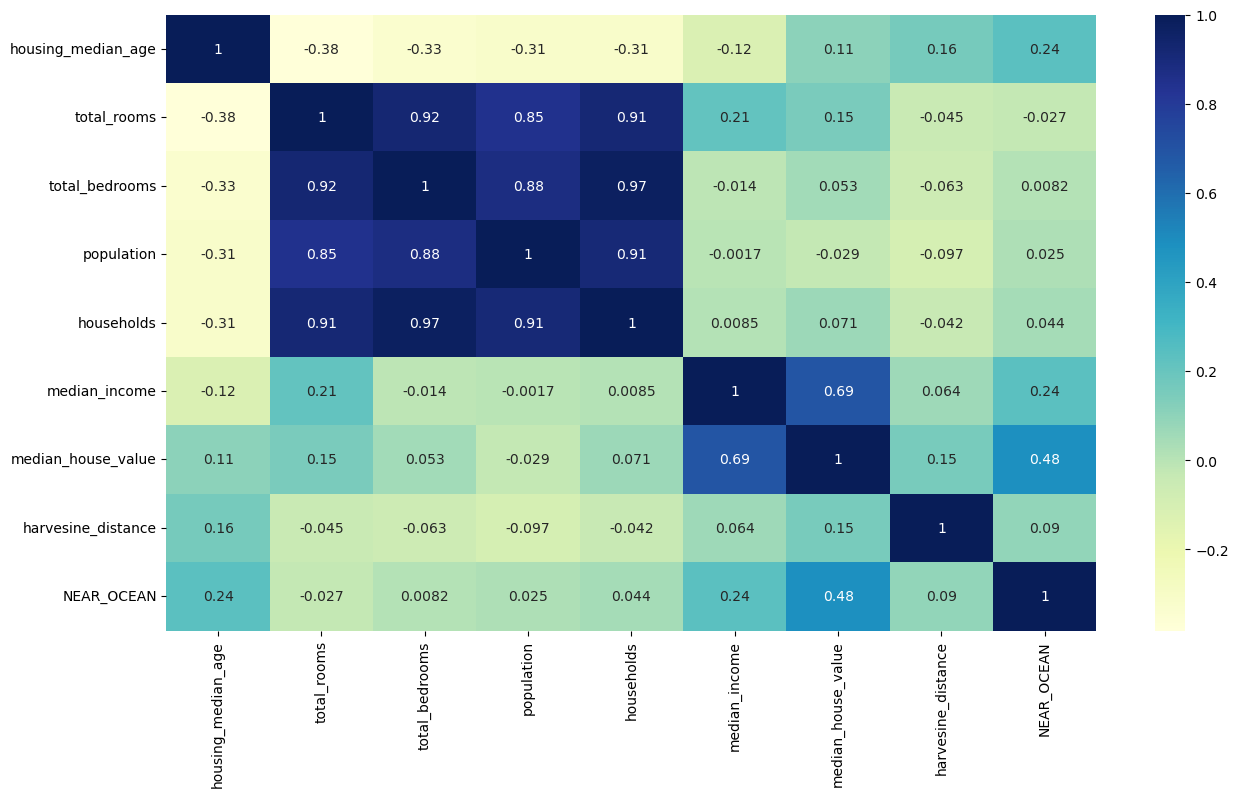

In [14]:
#analise de correlação
#retirando a variavel categorica pra analisar a correlacao
housing = housing.drop(['longitude', 'latitude', 'ocean_proximity'], axis=1)
plt.figure(figsize=(15,8))
sns.heatmap(housing.corr(), annot = True, cmap = "YlGnBu")

In [15]:
#as variaveis total_bedrooms/total_rooms e households/population são muito correlacionadas. Por isso,
#irei testar criar uma unica variavel que faça sentido com elas:

#criando uma variavel que proporciona a qtde de quartos para a qtde de comodos
#housing['prop_bedrooms_to_rooms'] = housing['total_bedrooms']/housing['total_rooms']
#essa variavel nao ficou boa, por isso nao será utilizada no modelo

#criando uma variavel que proporciona a qtde de moradias para populacao
housing['prop_household_to_pop'] = housing['households']/housing['population']

In [16]:
#para conseguir atingir um RMSE < 69.000 realiziamos alguns testes de transformação de variável
#o que consegui chegar na metrica exigida e manteve nossa predição positiva foram as transf. abaixo:
housing['housing_median_age2'] = housing['housing_median_age']*housing['housing_median_age']
housing['sqrt_median_house_value'] = housing['median_house_value'].apply(lambda x: sqrt(x))

#### 5. Drop de variaveis que nao sao mais uteis

In [17]:
#avabei nao usando harversine distance pq a proximidade do oceano ja descreve bem o problema
housing = housing.drop(['total_bedrooms', 'households','population','median_house_value','housing_median_age'], axis=1)

In [18]:
#iremos padronizar as variaveis para que elas fiquem na mesma escala e sejam comparaveis
#neste momento irei padronizar apenas para checar se ainda temos alguma correlacao muito 
#forte entre as variaveis e se alguma tem que ser retirada
ss_ = StandardScaler().fit(housing)
housing_scaled = pd.DataFrame(ss_.transform(housing))

<Axes: >

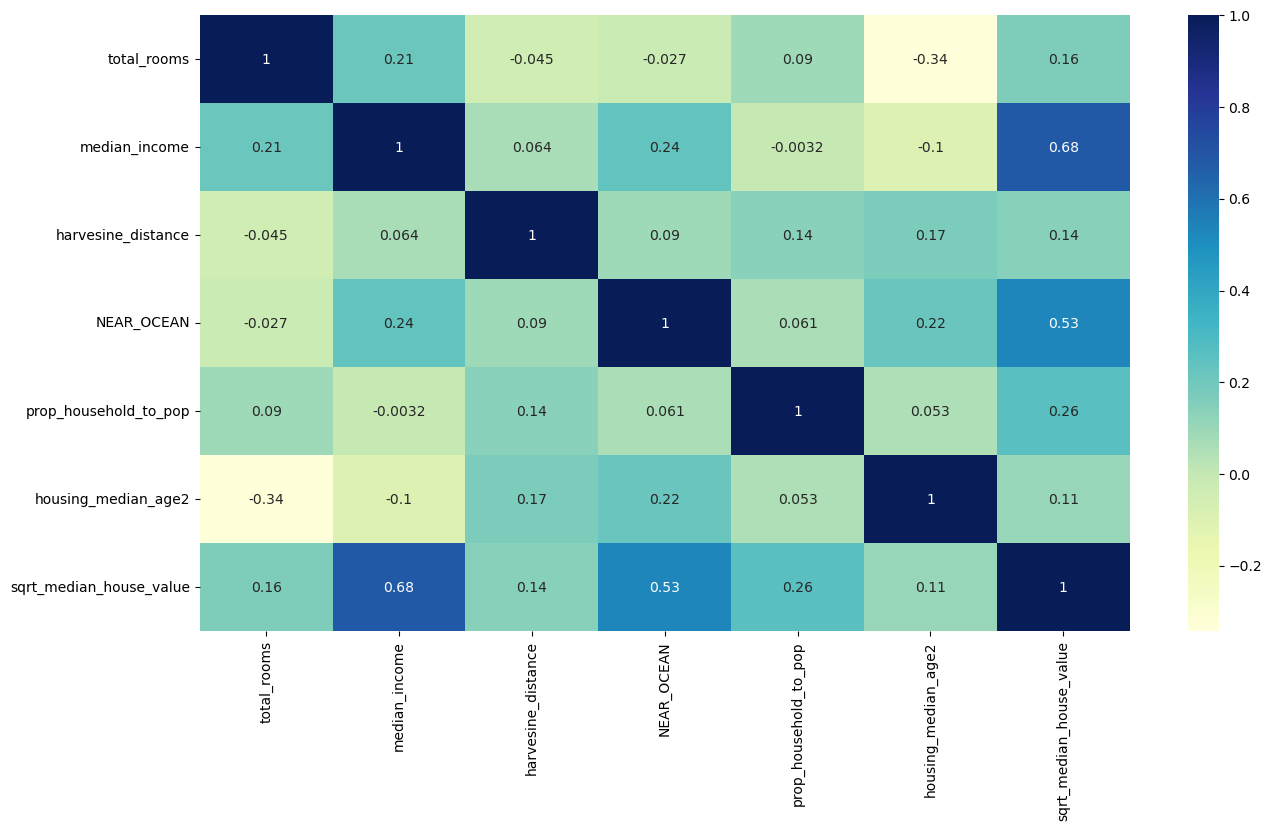

In [19]:
#a correlacao entre as variaveis ficou otima (a unica acima de 0.6 é com relacao ao nosso target)
plt.figure(figsize=(15,8))
sns.heatmap(housing.corr(), annot = True, cmap = "YlGnBu")

In [20]:
housing.columns

Index(['total_rooms', 'median_income', 'harvesine_distance', 'NEAR_OCEAN',
       'prop_household_to_pop', 'housing_median_age2',
       'sqrt_median_house_value'],
      dtype='object')

# Modelo

## Separação bases de treino e teste

In [21]:
#meu target sera a raiz quadrada da variavel
X = housing.drop("sqrt_median_house_value", axis=1)
y = housing['sqrt_median_house_value']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((14448, 6), (6192, 6), (14448,), (6192,))

#### Padronizacao das variaveis

In [22]:
#estou criando uma variavel para cada padronizacao para depois ser capaz de 
#inverter a transformacao em cada base a fim de analisar o resultado
y_train2 = pd.DataFrame(y_train)
y_test2 = pd.DataFrame(y_test)

ss_x_train = StandardScaler().fit(X_train)
X_train_scaled = ss_x_train.transform(X_train)

ss_x_test = StandardScaler().fit(X_test)
X_test_scaled = ss_x_test.transform(X_test)

ss_y_train = StandardScaler().fit(y_train2)
y_train_scaled = ss_y_train.transform(y_train2)

ss_y_test = StandardScaler().fit(y_test2)
y_test_scaled = ss_y_test.transform(y_test2)

In [23]:
#Aplicação da regressao linear, setando positive = TRUE para que os coeficientes
#sejam positivos, nos gerando predições positvas.
logreg = LinearRegression(positive = True)
logreg.fit(X_train_scaled, y_train_scaled)
Y_pred = logreg.predict(X_test_scaled)

In [24]:
#retornando a base de predito para escala original
Y_pred2 = pd.DataFrame(Y_pred)
y_pred_normal = ss_y_test.inverse_transform(Y_pred2)

In [25]:
#analisando o predito versus observado (voltando a escala do target ao normal) e calculando o RMSE
y_true = y_test*y_test
y_pred = y_pred_normal*y_pred_normal
mean_squared_error(y_true, y_pred, squared=False)
#RMSE = 68478.23710359524

68478.23710359524

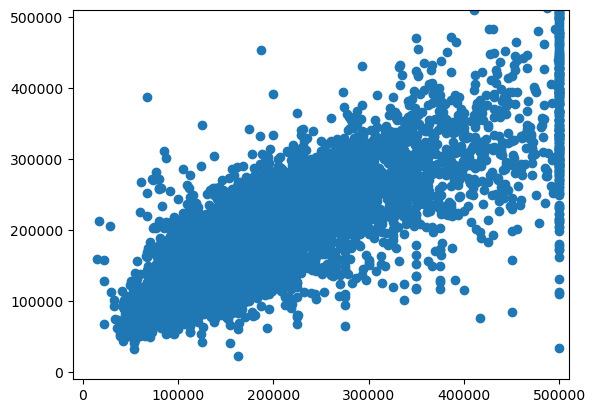

In [26]:
#scatter plot do observado vs predito
plt.xlim(-10000, 510000)
plt.ylim(-10000, 510000)
plt.scatter(y_true, y_pred)
#nos mostra que temos alguns pontos de outlier que foram preditos

In [27]:
#garantindo que nao estamos prevendo valores negativos - deve vir vazio
y_pred2 = pd.DataFrame(y_pred, columns = ['Predicao'])
y_pred2[y_pred2['Predicao']< 0]

,Predicao


In [28]:
#metricas do modelo
sm.add_constant(X)
mod = sm.OLS(y, X)
logreg = mod.fit()
print(logreg.summary())
#p valores todos abaixo de 0.05
#R quadrado de 0.975, nos dizendo que há pequenas diferencas entre o observado e o predito

                                   OLS Regression Results                                   
Dep. Variable:     sqrt_median_house_value   R-squared (uncentered):                   0.975
Model:                                 OLS   Adj. R-squared (uncentered):              0.975
Method:                      Least Squares   F-statistic:                          1.359e+05
Date:                     Sat, 16 Dec 2023   Prob (F-statistic):                        0.00
Time:                             23:14:37   Log-Likelihood:                     -1.1740e+05
No. Observations:                    20640   AIC:                                  2.348e+05
Df Residuals:                        20634   BIC:                                  2.349e+05
Df Model:                                6                                                  
Covariance Type:                 nonrobust                                                  
                            coef    std err          t      P>|t|     